In [1]:
using DataFrames
using Gadfly


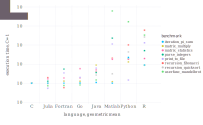

In [16]:
# Load benchmark data from file
    benchmarks = readtable("benchmarks.csv", header=false, names=[:language, :benchmark, :time])

    # Capitalize and decorate language names from datafile
    dict = Dict("c"=>"C", "julia"=>"Julia", "lua"=>"LuaJIT", 
                "fortran"=>"Fortran", "java"=>"Java",
                "javascript"=>"JavaScript", "matlab"=>"Matlab", 
                "mathematica"=>"Mathe-\nmatica", "python"=>"Python", 
                "octave"=>"Octave", "r"=>"R", "go"=>"Go")

    benchmarks[:language] = [dict[lang] for lang in benchmarks[:language]]

    # Normalize benchmark times by C times
    ctime = benchmarks[benchmarks[:language].== "C", :]
    benchmarks = join(benchmarks, ctime, on=:benchmark)
    delete!(benchmarks, :language_1)
    rename!(benchmarks, :time_1, :ctime)
    benchmarks[:normtime] = benchmarks[:time] ./ benchmarks[:ctime];

    # Compute the geometric mean for each language
    langs = [];
    means = [];
    priorities = [];
    for lang in values(dict)
        data = benchmarks[benchmarks[:language].== lang, :]
        gmean = geomean(data[:normtime])
        push!(langs, lang)
        push!(means, gmean)
        if (lang == "C")
            push!(priorities, 1)
        elseif (lang == "Julia")
            push!(priorities, 2)        
        else
            push!(priorities, 3)
        end
    end

    for lang in values(dict)
    # Add the geometric means back into the benchmarks dataframe
    langmean = DataFrame(language=langs, geomean = means, priority = priorities)
    benchmarks = join(benchmarks, langmean, on=:language)

    # Put C first, Julia second, and sort the rest by geometric mean
    sort!(benchmarks, cols=[:priority, :geomean]);

    p = plot(benchmarks,
             x = :language,
             y = :normtime,
             color = :benchmark,
             Scale.y_log10,
             Guide.ylabel("execution time, C=1"),
             Guide.xlabel("language, geometric mean"),
             Coord.Cartesian(xmin=1,xmax=8.5,ymin=-1,ymax=4),
             Theme(
                   guide_title_position = :left,
                   colorkey_swatch_shape = :circle,
                   minor_label_font = "Georgia",
                   major_label_font = "Georgia",
                   key_label_font = "Georgia",
                   minor_label_font_size = 12pt,
                   major_label_font_size = 12pt,
                   key_label_font_size = 10pt,
                   ),
    )
    draw(SVG(8inch,8inch/golden), p)
    
    # Mathematica has a newline so it fits as a label in the plot.
    # Remove it for the text list of languages and geometric means.
    for i in 1:length(langs)
      if langs[i] == "Mathe-\nmatica"
          langs[i] = "Mathematica"
          break
      end
    end

In [13]:
draw(SVG("benchmarks.svg", 8inch, 8inch/golden), p)

false

In [14]:
    perm = sortperm(means)
    println("cputime\tlang") 
    for p in perm
        #println("$(means[p])\t$(langs[p])")
        @printf "%0.3f\t%s\n" means[p] langs[p]
        #@show means[p], langs[p]
    end

cputime	lang
1.000	C
1.053	Julia
1.501	Fortran
1.514	Go
3.360	Java
26.142	Matlab
31.971	Python
69.574	R
NaN	Octave
NaN	LuaJIT
NaN	JavaScript
NaN	Mathematica
